# Fake News Detection

## Inleiding

Nepnieuws is misleidende en onjuiste informatie, die wordt verspreid om vooral geld te verdienen of om publieke opinie te beïnvloeden. Veel websites en social media accounts staan vol met berichten die soms totaal bij elkaar verzonnen zijn of die deels niet waar zijn. Bij het lezen van deze berichten zou je je kunnen afvragen in hoeverre het waar is. Iedereen kan in een nepbericht trappen. "De gevolgen ervan kunnen groot zijn. Fake Berichten hebben zo bijvoorbeeld de mogelijkheid om verkiezingen te beïnvloeden. Aangezien deze heel snel verspreid kunnen worden, is het ook gemakkelijk om de publieke opinie te beïnvloeden. 

Het is dus handig om nepnieuws te herkennen. Alleen vindt niet iedereen dit even makkelijk. Wat nou als je binnen één klik kunt weten of iets nep nieuws is? Dat is dus de doel van dit verslag. 

## Dataset

#### Importeer libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
import shap

import warnings
warnings.filterwarnings('ignore')


#### Load data

In [3]:
real = pd.read_csv('True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<mark>Insights<mark>

- Er zijn 4 kolommen
- Alle kolommen zien eruit als strings
- Er zijn geen labels
- De kolommen van de ene dataset komen overeen met de kolommen van de ander

## Analyse probleem

**Wat is het probleem?**

We willen voorspellen of een bericht echt of nepnieuws is d.m.v. een aantal Machine learning modellen.

<br>

**Wat voor label heb je?**

Er zij nog geen labels beschikbaar. Bij het combineren van de twee datasets moet er een label worden aangemaakt met fake news. De neppe artikelen krijgen de waarde 0 en de anderen een 1.

<br>

**Dimensie dataset**

In [5]:
real.shape, fake.shape

((21417, 4), (23481, 4))

**Soorten data/features**

In [6]:
print('Info for real:')
print(real.info())
print()
print('-'*50)
print('\nInfo for fake:')
print(fake.info())

Info for real:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None

--------------------------------------------------

Info for fake:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


<mark>Insights<mark>

- De datasets bevatten beide zo'n 22000 rijen.
- Beide datasets bevatten vier kolommen
- De types van de kolommen zijn allemaal hetzelfde

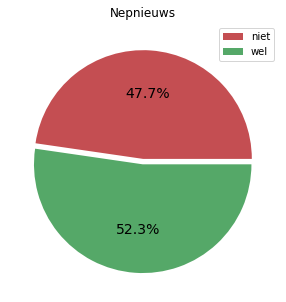

In [7]:
amount_of_rows_real = real.shape[0]
amount_of_rows_fake = fake.shape[0]

#define Seaborn color palette to use
colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn. Niet dat 90% van de data wel borstkanker heeft en maar 10% niet o.i.d. Je kunt dus zien dat het 
# 40/60 verdeeld is. Dat is nog prima.
plt.figure(figsize=(5,5))
plt.pie([amount_of_rows_real, amount_of_rows_fake], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['niet','wel'])
plt.title('Nepnieuws')
plt.show()

<mark>Insights<mark>

- Er zijn iets meer berichten dat nepnieuws zijn
- Redelijk in balans

## Voorspelling

**Welke classifier zal het beste zijn en waarom?**

Ik denk dat Naive Bayes het best zal werken, omdat er wordt gewerkt met tekst als data. Naive Bayes kan hier namelijk goed mee werken.

<br>

**Welke hyperparameters zijn relevant en waarom?**

De alpha parameter is belangrijk. Deze parameter zorgt voor "smoothing" bij deze classifier. Als het op 0 wordt gelaten dan is er geen sprake van "smoothing".
"It is problematic when a frequency-based probability is zero, because it will wipe out all the information in the other probabilities. A way to solve this is with smoothing." 

<br>

## Methoden

**Welke pre-processing stappen zijn nodig?**

- label toevoegen aan de datasets met real/fake (0/1)
- datasets bij elkaar voegen
- checken of er lege velden of NaN-waardes zijn
- Feature Selection
- Text processing:
    1. tekst -> kleine letters
    2. als er urls inzitten, eruit halen/ wijzigen naar URL
    3. extra spaties eruit halen
    4. woorden in een tekst naar de stam brengen
    5. tellen hoevaak een woord voorkomt in alle teksten

<br>

**Welke classifiers ga je vergelijken?**

- Logistic Regression
- Naive Bayes
- Support Vector Machine
- LSTM
- Dense netwerk

**Welke performance metric is passend?**

Accuracy score

#### Label toevoegen

<br>Maak de labels aan. Geef nepnieuws aan met 1 en de rest met 0.

In [8]:
real['is_real'] = 1
fake['is_real'] = 0

#### Datasets aan elkaar toevoegen

In [9]:
data = pd.concat([real, fake], ignore_index=True)

data

,title,text,subject,date,is_real
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


#### Lege cellen / duplicates check

In [10]:
data.isna().sum()

title      0
text       0
subject    0
date       0
is_real    0
dtype: int64

In [11]:
data.duplicated().sum()

209

In [12]:
data.drop_duplicates(inplace=True)

<mark>Insights<mark>

- In beide datasets zijn er geen lege waardes
- de dataset bevat 209 duplicated waardes

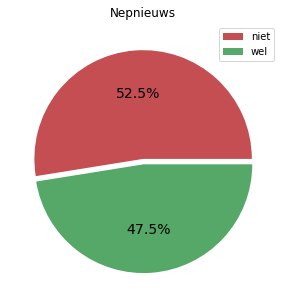

In [13]:
amount_of_rows_real = data[data['is_real'] == 0]['is_real'].count()
amount_of_rows_fake = data[data['is_real'] == 1]['is_real'].count()

#define Seaborn color palette to use
colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn.
plt.figure(figsize=(5,5))
plt.pie([amount_of_rows_real, amount_of_rows_fake], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['niet','wel'])
plt.title('Nepnieuws')
plt.show()

**Insights**
- de datasets zijn in balas (inclusief duplications).
- verdeling van 52% fake - 48% real

**Title**

Zet de text en title kolom aan elkaar. Titel is ook immers een deel van de tekst.

In [14]:
data["text"] = data['title'] + ' ' +  data['text']

data.drop(columns=['title'], axis=1, inplace=True)

data['text'][0][:255]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself '

<strong>Date</strong>

Ik denk niet echt dat er een sterke correlatie tussen datum en nepnieuws is. Deze kan dus ook verwijderd worden

In [15]:
data.drop(columns=['date'], axis=1, inplace=True)

data

,text,subject,is_real
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,1
1,U.S. military to accept transgender recruits o...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,politicsNews,1
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,Middle-east,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,Middle-east,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Middle-east,0
44896,How to Blow $700 Million: Al Jazeera America F...,Middle-east,0


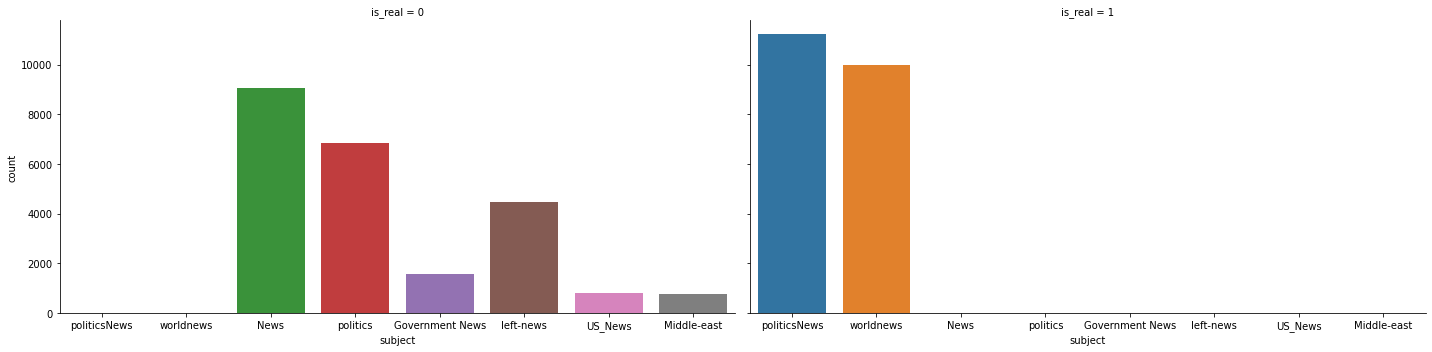

In [16]:
sns.catplot(x='subject', col='is_real', data=data, kind='count', aspect=2)

<mark>Insights<mark>

- Fakenews heeft heel wat categorien vergeleken met echt nieuws.
- Echt nieuws gaat alleen maar over politiek en worldnieuws.
- De dataset is zeker biased. Als we de kolom erin laten, alle fakeniews zijn politicsnews en worldnews. Als het wat anders is, weet de model dat het fakenews is. Dit willen we niet. Daarom kan de subject kolom eruit.

Verwijder subject

In [17]:
data.drop('subject', axis=1, inplace=True)

#### Text pre-processing

In [12]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [18]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [19]:
def clean_text(text):
    text = text.lower()

    # vervang alle urls
    text = re.sub('https?://\S+|www\.\S+', 'HTTPADDR', text)
    
    # verwijder punctuation
    text = text.translate(str.maketrans('','', string.punctuation))
    # vervang emojis door  'EMOJI'
    text = emoji.demojize(text)
    text = re.sub(r"\:(.*?)\:", ' EMOJI ',text)
    # vervang getallen door 'NUMMER'
    text = re.sub(r"\b[\d.]+\b", " NUMMER ", text)
    # vervang opeenvolgende spaties en tabs door een enkele spatie
    text = re.sub(r"\s+", " ", text)

    # Removing the stopwords from text
    new_text = []

    tokenized = word_tokenize(text)

    for word in tokenized:
        if word not in stop_words:
            word = word.strip() # haal spaties aan uiteinde weg
            word = lemmatizer.lemmatize(word) # rocks -> rock, better -> good, running -> run
            new_text.append(word)

    
    
    text = ' '.join(lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words)
    

    # verwijder onnodige spaties aan begin en eind
    text = text.strip()

    return text


In [20]:
data['text'] = [clean_text(text) for text in data['text']]

data['text'][0][:500]

'u budget fight loom republican flip fiscal script washington reuters head conservative republican faction u congress voted month huge expansion national debt pay tax cut called “ fiscal conservative ” sunday urged budget restraint NUMMER keeping sharp pivot way among republican u representative mark meadow speaking cbs ’ “ face nation ” drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immig'

Nu zijn de twee datasets letterlijk onder elkaar geplakt. Voor het trainen van modellen lijkt het me handig als de data door elkaar heen is. 

In [21]:
data = data.sample(frac=1)

data

,text,is_real
43894,‘ ’ ’ – hillary clinton losing support millenn...,0
39658,debbie wasserman schultz planned continue pay ...,0
40568,lol high school student skip school protest tr...,0
44482,last minute gov ’ grab obama admin decree dhs ...,0
11267,obama say willing work republican speaker pove...,1
...,...,...
38333,dnc chair asks democrat member congress “ brin...,0
19005,russian bomber fire cruise missile islamic sta...,1
7394,pledging unwavering defence nato brace trump b...,1
36178,black life matter terrorist may shut mall amer...,0


features & labels

In [22]:
X = data['text']
y = data['is_real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tf-idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended
# to reflect how important a word is to a document in a collection or corpus.
tfidf = TfidfVectorizer(max_features=10000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [24]:
X_train.shape, X_test.shape

((35751, 10000), (8938, 10000))

### Model training

##### Logistic Regression

In [25]:
lr = LogisticRegression(random_state=42, C=100, max_iter=1000)

lr.fit(X_train, y_train)

pred_test = lr.predict(X_test)
pred_train = lr.predict(X_train)

lr_acc_score_test = accuracy_score(pred_test, y_test)
lr_acc_score_train = accuracy_score(pred_train, y_train)

print(f"The accuracy in trainset of the logistic regression classifer is: {lr_acc_score_train}")
print(f"The accuracy in testset of the logistic regression classifer is: {lr_acc_score_test}")

The accuracy in trainset of the logistic regression classifer is: 1.0
The accuracy in testset of the logistic regression classifer is: 0.9954128440366973


- C=1: 0.9871
- C=10: 0.9940
- C=100: 0.9954

##### Naive Bayes

In [26]:
# Gebruik Multinominal, omdat data multinominal verdeeld is => goed voor word count problemen
nb = MultinomialNB(alpha=0, fit_prior=False)

nb.fit(X_train, y_train)

nb_pred_test = nb.predict(X_test)
nb_pred_train = nb.predict(X_train)

nb_acc_score_test = accuracy_score(nb_pred_test, y_test)
nb_acc_score_train = accuracy_score(nb_pred_train, y_train)

print(f"The accuracy of trainset of the naive bayes classifer is: {nb_acc_score_train}")
print(f"The accuracy of testset of the naive bayes classifer is: {nb_acc_score_test}")

The accuracy of trainset of the naive bayes classifer is: 0.9462112947889569
The accuracy of testset of the naive bayes classifer is: 0.9390243902439024


- alpha=1 (default): 0.9368
- alpha=2: 0.9338
- alpha=0: 0.9555
- alpha=0.5: 0.9416
- alpha-0.1: 0.9469

- fit_prior true (default): 0.9555
- fit_prior false: 0.9560

##### SVM

In [27]:
from sklearn.svm import SVC

svc = SVC(C=1, gamma=1, kernel='linear', probability=True)

svc.fit(X_train, y_train)

SVC(C=1, gamma=1, kernel='linear', probability=True)

In [28]:
pred = svc.predict(X_test)
accuracy_score(y_test, pred)

0.9953009621839337

Explainable AI: Shap

In [29]:
shap.initjs()
X_train_sample = shap.sample(X_train, 5)
X_test_sample = shap.sample(X_test, 4)

In [30]:
shapley = shap.KernelExplainer(svc.predict, X_train_sample)
shap_values = shapley.shap_values(X_test_sample)

  0%|          | 0/4 [00:00<?, ?it/s]

De force plt hieronder laat zien hoe de contributie van features zijn. De 1.00 is de models score. Scores lager dan 1 predicten fake en hoger dan 1 predicten niet fake.

In [62]:
test_X_df = pd.DataFrame(X_test_sample.todense())
shap.force_plot(shapley.expected_value, shap_values[-1, :], test_X_df.iloc[-1, :], feature_names=tfidf.get_feature_names())

<mark>Insights</mark>

- Het voorbeeld hierboven wordt geclassiviceerd als 1, omdat de contributie van higher groter is dan lower. 

<br>

Maar het vertelt ons nu niet hoe elke functie ertoe doet. Als een feature gemiddeld permutatiebelang heeft, kan dat betekenen dat het:

- een groot effect voor een paar voorspellingen, maar geen effect in het algemeen, of
- een gemiddeld effect voor alle voorspellingen

Daarom nu een summary plot

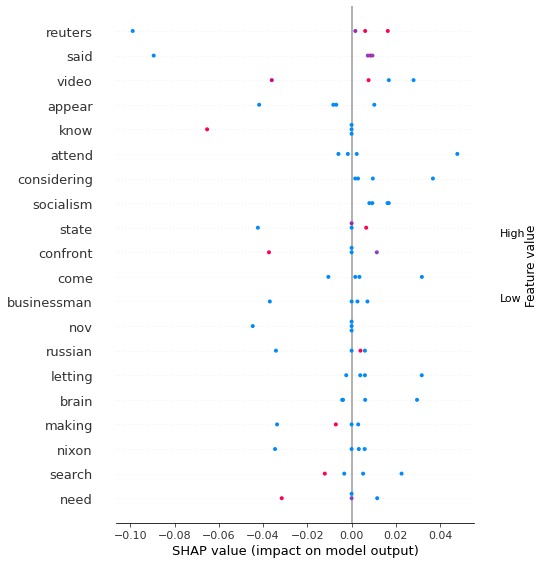

In [65]:
shap.summary_plot(shap_values, test_X_df ,feature_names=tfidf.get_feature_names(), class_names=["real", "fake"])

- Verticaal geeft het de features weer. Horizontaal laat het zien of het effect een hogere of lagere voorspelling heeft veroorzaakt. De kleur geeft aan of de feature high of low is voor die rij.

Voorbeeld: het puntje linksboven is van blauwe kleur en dit betekent dat het woord ''reuters' voor -0.10 lagere voorspelling heeft veroorzaakt.

### Resultaten

In [29]:
def plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std):
    plt.subplots(1, figsize=(10,10))
    plt.grid()
    plt.plot(train_sizes, train_mean, "o-", color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)


    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

#### Logistic Regression

|                          	| 1 (default) 	| 10     	| 0.1     	| 100   	| 400  |
|--------------------------	|-------------	|-------	|-------	|-------	|------|
| C                        	| 0.988       	| 0.9935 	| 0.950 	| 0.9948 	| <mark>0.9956</mark> |

C boven de 175 (zoals 1000) geeft dezelfde resultaat.

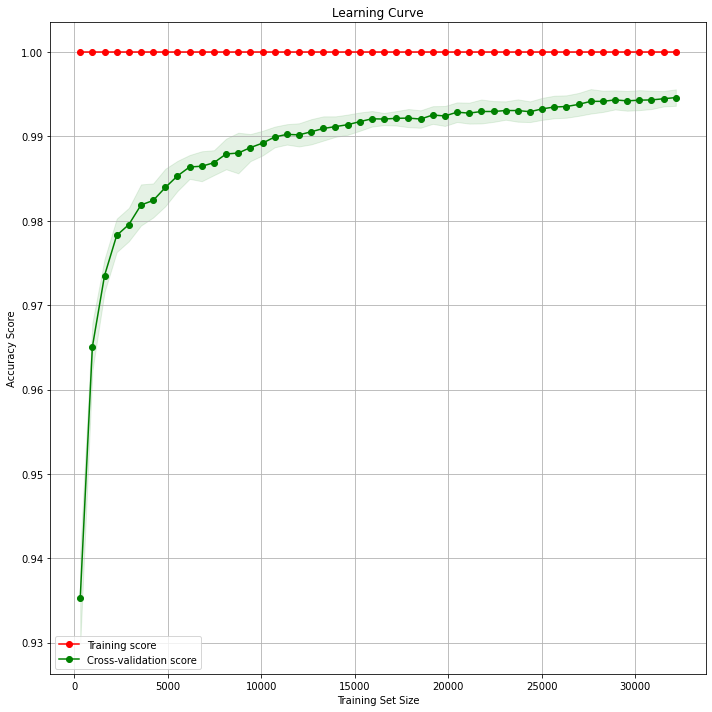

In [30]:
train_sizes, train_scores, test_scores = learning_curve(lr, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std)

**Insights**
- Geen sprake van overfitting
- weinig loss
- begint stabiel te woden na ongeveer 10000

#### Naive Bayes

fit_prior = True (default):

|                          	| 1 (default) 	| 2     	| 0     	| 0.1   	|
|--------------------------	|-------------	|-------	|-------	|-------	|
| Alpha                    	| 0.936       	| 0.934 	| 0.9555 	| 0.946 	|

fit_prior = False:

|                          	| 1 (default) 	| 2     	| 0     	| 0.1   	|
|--------------------------	|-------------	|-------	|-------	|-------	|
| Alpha                    	| 0.937       	| 0.935 	| <mark>0.9560</mark> 	| 0.947 	|


fit_prior=False met alpha 0 komt op de hoogste accuracy.

In [31]:
train_sizes, train_scores, test_scores = learning_curve(nb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:55

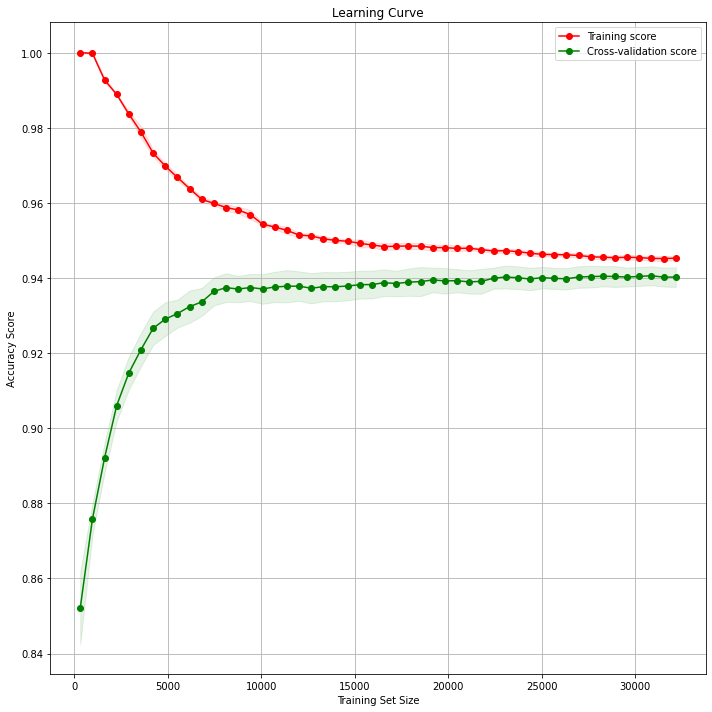

In [32]:
plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std)

**Insights**
- training score gaat op z'n tijd ook een beetje achteruit
- Lijkt al iets meer op underfitting

### LSTM

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [80]:
X = data['text']
y = data['is_real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

fit_on_texts alleen op X_train gebruiken. Als je het op hele dataset doet, wordt het biased.

In [81]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [82]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [83]:
X_train = pad_sequences(X_train, padding='post', maxlen=250)
X_test = pad_sequences(X_test, padding="post", maxlen=250)

In [49]:
model = Sequential()

model.add(Embedding(max_words, 128))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
# model.add(Bidirectional(LSTM(16)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=64, shuffle=True)

Epoch 1/10


2022-04-27 20:51:07.471358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:51:07.971987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:51:07.991528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:51:08.967228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:51:08.996065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


503/503 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.8881

2022-04-27 20:53:05.485030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:53:05.666138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 20:53:05.680887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


503/503 [==============================] - 125s 240ms/step - loss: 0.2398 - accuracy: 0.8881 - val_loss: 0.0839 - val_accuracy: 0.9676
Epoch 2/10
503/503 [==============================] - 116s 232ms/step - loss: 0.0644 - accuracy: 0.9779 - val_loss: 0.0528 - val_accuracy: 0.9846
Epoch 3/10
503/503 [==============================] - 118s 234ms/step - loss: 0.0580 - accuracy: 0.9802 - val_loss: 0.0815 - val_accuracy: 0.9698
Epoch 4/10
503/503 [==============================] - 116s 231ms/step - loss: 0.0608 - accuracy: 0.9793 - val_loss: 0.0503 - val_accuracy: 0.9849
Epoch 5/10
503/503 [==============================] - 117s 232ms/step - loss: 0.0404 - accuracy: 0.9856 - val_loss: 0.0395 - val_accuracy: 0.9877
Epoch 6/10
503/503 [==============================] - 1461s 3s/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0475 - val_accuracy: 0.9860
Epoch 7/10
503/503 [==============================] - 719s 1s/step - loss: 0.0249 - accuracy: 0.9919 - val_loss: 0.0397 - val_accuracy: 0

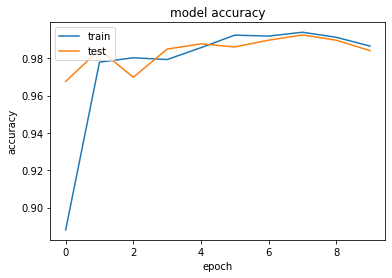

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

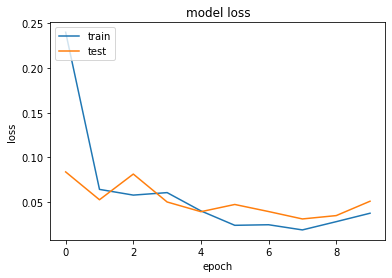

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
model = Sequential()

model.add(Dense(max_words))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [89]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=64, shuffle=True)

Epoch 1/10


2022-04-28 01:06:54.980193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


503/503 [==============================] - ETA: 0s - loss: 25.6435 - accuracy: 0.5141

2022-04-28 01:07:00.677085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


503/503 [==============================] - 6s 11ms/step - loss: 25.6435 - accuracy: 0.5141 - val_loss: 0.6906 - val_accuracy: 0.5187
Epoch 2/10
503/503 [==============================] - 6s 11ms/step - loss: 0.6906 - accuracy: 0.5261 - val_loss: 0.6907 - val_accuracy: 0.5187
Epoch 3/10
503/503 [==============================] - 5s 11ms/step - loss: 0.6935 - accuracy: 0.5262 - val_loss: 0.6914 - val_accuracy: 0.5187
Epoch 4/10
503/503 [==============================] - 5s 11ms/step - loss: 0.6985 - accuracy: 0.5262 - val_loss: 0.6915 - val_accuracy: 0.5187
Epoch 5/10
503/503 [==============================] - 5s 11ms/step - loss: 0.6903 - accuracy: 0.5262 - val_loss: 0.6916 - val_accuracy: 0.5187
Epoch 6/10
503/503 [==============================] - 5s 11ms/step - loss: 0.7024 - accuracy: 0.5261 - val_loss: 0.6920 - val_accuracy: 0.5190
Epoch 7/10
503/503 [==============================] - 5s 11ms/step - loss: 0.6917 - accuracy: 0.5261 - val_loss: 0.6920 - val_accuracy: 0.5190
Epoch 8/1

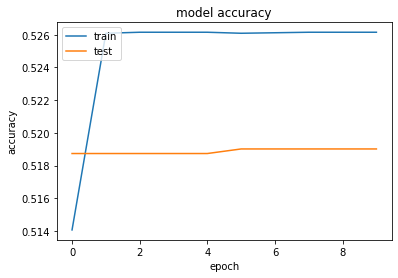

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<mark>Insights</mark>

- Duidelijk spraak van overfitting
- lage accuracy score

### Conclusie

Voor het voorspellen van real/fake news in deze dataset is het gebruik van Logistic Regression beter dan Naive Bayes. LR komt met 'optimale' parameters op een accuracy score van 9.995 uit. Het is ook niet overtrained of undertrained. Als je C ook gewoon op default zet, krijg je een accuracy van 0.98. SVM doet het bijna net zo goed als LR. Dit had ik niet verwacht. 

Dit klopt niet met mijn voorspelling. Ik dacht dat Naive Bayes het beter zou doen. Mijn redenering hiervoor is dat Naive Bayes goed kan werken met teskst, alleen realiseer ik me nu dat we de tekst natuurlijk veranderd hebben ik een matrix met getallen (TF-IDF). Dus mijn redenering klopt niet. 

LSTM is zeker ook een goede optie voor fake news detection. Deze had ik wel al verwacht, aangezien RNN goed is voor teksten. Een normale dense netwerk is niet goed voor tekst problemen. Dat is hieruit op te merken.

**Hoe kan ik het verbeteren?**
- GridSearchCV gebruiken om echt de optimale hyperparameters te vinden
- Cross-validation toepassen
- train_test_split op verschillende test_sizes testen

### Bronnen

- https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes
- https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
- https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
- https://medium.com/@HemantSingh0/fake-news-detection-with-python-fcdc60675bf0
- https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
- https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial
- https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf